# Example: Convolutional Neural Networks

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [33]:
using Flux
using Plots
using JuMP
using Gurobi
using Random
using Gogeta
using Images
using FileIO
using TestImages

Suppose we have a trained CNN with some weights and we would like to formulate it as a MIP problem. In our case we generate it with random weights:

In [34]:
Random.seed!(1234)
CNN_model = Flux.Chain(
    Conv((4,3), 1 => 10, pad=(2, 1), stride=(3, 2), relu),
    MeanPool((5,3), pad=(3, 2), stride=(2, 2)),
    MaxPool((3,4), pad=(1, 3), stride=(3, 2)),
    Conv((4,3), 10 => 5, pad=(2, 1), stride=(3, 2), relu),
    MaxPool((3,4), pad=(1, 3), stride=(3, 2)),
    Flux.flatten,
    Dense(20 => 100, relu),
    Dense(100 => 1)
)

Chain(
  Conv((4, 3), 1 => 10, relu, pad=(2, 1), stride=(3, 2)),  # 130 parameters
  MeanPool((5, 3), pad=(3, 2), stride=2),
  MaxPool((3, 4), pad=(1, 3), stride=(3, 2)),
  Conv((4, 3), 10 => 5, relu, pad=(2, 1), stride=(3, 2)),  # 605 parameters
  MaxPool((3, 4), pad=(1, 3), stride=(3, 2)),
  Flux.flatten,
  Dense(20 => 100, relu),               # 2_100 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 8 arrays, 2_936 parameters, 12.609 KiB.

<span style="color: red;">First, let's import a sample image:</span>


At first lets import some sample image:

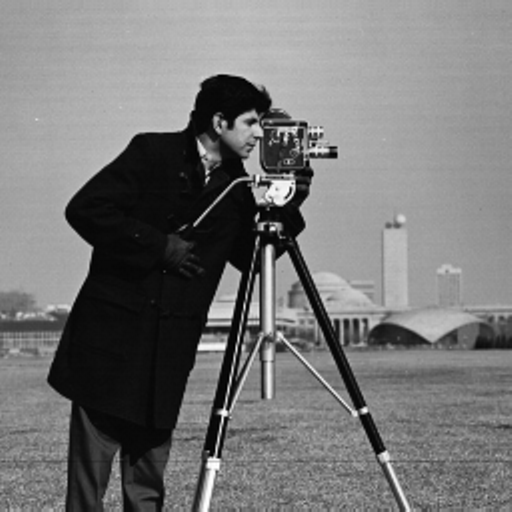

In [35]:
image = testimage("cameraman.tif")

Then, we need to make some preprocessing

In [36]:
downscaled_image = imresize(image, (70, 50));
input = reshape(Float32.(channelview(Gray.(downscaled_image))), 70, 50, 1, 1);
input = input[end:-1:1, :, :, :];

The input looks as follows:

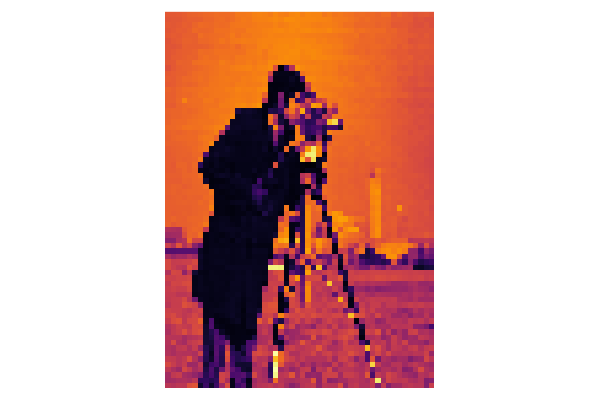

In [37]:
display(MIME"image/png"(), heatmap(input[:, :, 1, 1], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)))

Now at each layer CNN produces different images with different properties and sizes and we want to replicate the output of each layer with a MIP. 

For now, lets look at outputs of CNN at each layer.

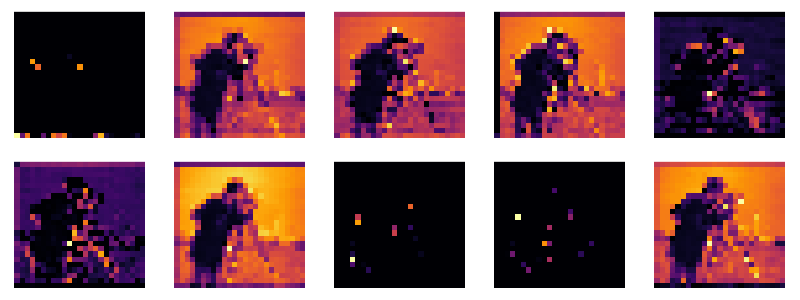

In [48]:
# convolution layer outputs
outputs = [CNN_model[1](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
display(MIME"image/png"(), plot(heatmaps..., layout=(2, 5), size=(800, 300)))

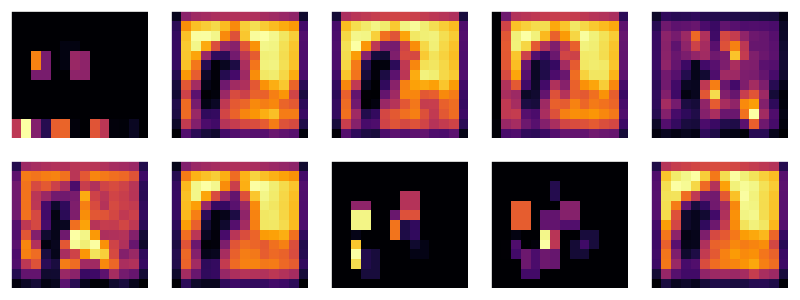

In [49]:
# meanpool outputs
outputs = [CNN_model[1:2](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
display(MIME"image/png"(), plot(heatmaps..., layout=(2, 5), size=(800, 300)))

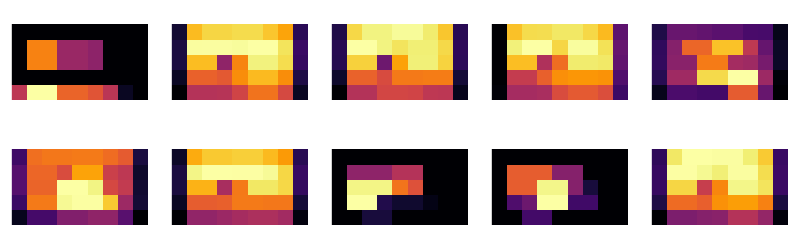

In [50]:
# maxpool
outputs = [CNN_model[1:3](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
display(MIME"image/png"(), plot(heatmaps..., layout=(2, 5), size=(800, 250)))

<span style="color: red;">change new conv for convolution layer here 
</span>


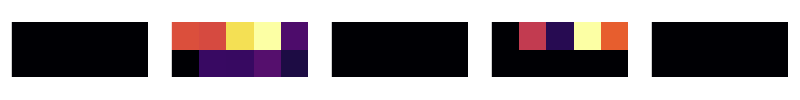

In [51]:
# new conv
outputs = [CNN_model[1:4](input)[:, :, channel, 1] for channel in 1:5];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:5]
display(MIME"image/png"(), plot(heatmaps..., layout=(1, 5), size=(800, 100)))

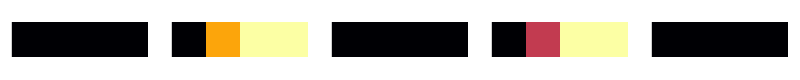

In [52]:
# last maxpool
outputs = [CNN_model[1:5](input)[:, :, channel, 1] for channel in 1:5];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:5]
display(MIME"image/png"(), plot(heatmaps..., layout=(1, 5), size=(800, 80)))

To formulate CNN as a MIP problem, you need to call `get_structure()` function with input parameters: CNN_model and input image to get all neccessary information about the problem. 

Then, you need to call `CNN_formulate!()` with input arguments: jump model (innitialized empty model), CNN and information about structure of CNN 

In [58]:
# create jump model from cnn
jump = Model(Gurobi.Optimizer)
set_silent(jump)
cnns = get_structure(CNN_model, input);
CNN_formulate!(jump, CNN_model, cnns);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Formulating CNN as JuMP model...
Preprocessing completed
Added conv layer
Added meanpool layer
Added maxpool layer
Added conv layer
Added maxpool layer
Added flatten layer
Added dense layer
Added dense layer
Formulation complete.


Now we have a jump model with constraints and variables that produces the same output as CNN

In [44]:
jump

A JuMP Model
Maximization problem with:
Variables: 29901
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8461 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 5740 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 17940 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 3500 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 17990 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 11790 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: c, cs, cz, s, x, z

With our formulation, you can choose which layer you are interested in and just call `image_pass!()`. This function has next input parameters:
- jump_model – the CNN model formulation that you got after calling `CNN_formulate!()`
- input – preprocessed input image
- cnns – the output that you got with `get_structure()`
- layer - the layer you are interested in (indexing starts from 1)

In [55]:
layer = 1
image_pass!(jump, input, cnns, layer) ;

<span style="color: red;">We can easily verify that the output is the same by calling the function image_pass!(jump, input, cnns, i), where i is the index of the layer you are interested in. In the output message, you will see if each layer is approximately the same and the time required to run the code. 
</span>


We can easily check that the output is the same by calling function `image_pass!(jump, input, cnns, i)`, where `i` is the index of the layer you are interested in. In the output message you will see is each layer is approximately the same and then time it is needed to run the code.

In [45]:
# Test that jump model produces same outputs for all layers as the CNN

@time println("Conv layer 1, approximately the same = ", CNN_model[1](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 1))
@time println("MeanPool 1, approximately the same = ", CNN_model[1:2](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 2))
@time println("MaxPool 2, approximately the same = ", CNN_model[1:3](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 3))
@time println("Conv layer 2, approximately the same = ", CNN_model[1:4](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 4))
@time println("MaxPool, approximately the same = ", CNN_model[1:5](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 5))
@time println("Flatten, approximately the same = ", vec(CNN_model[1:6](input)) ≈ image_pass!(jump, input, cnns, 6))
@time println("Dense 1, approximately the same = ", vec(CNN_model[1:7](input)) ≈ image_pass!(jump, input, cnns, 7))
@time println("Dense 1, approximately the same = ", vec(CNN_model[1:8](input)) ≈ image_pass!(jump, input, cnns, 8))
@time println("Output, approximately the same = ", vec(CNN_model(input)) ≈ image_pass!(jump, input))

Conv layer 1, approximately the same = true
  0.131807 seconds (514.49 k allocations: 45.729 MiB, 9.09% gc time)
MeanPool 1, approximately the same = true
  0.029407 seconds (50.42 k allocations: 1.275 MiB)
MaxPool 2, approximately the same = true
  0.028939 seconds (25.78 k allocations: 704.359 KiB)
Conv layer 2, approximately the same = true
  0.028870 seconds (18.75 k allocations: 552.859 KiB)
MaxPool, approximately the same = true
  0.029095 seconds (18.10 k allocations: 529.172 KiB)
Flatten, approximately the same = true
  0.028361 seconds (18.11 k allocations: 529.984 KiB)
Dense 1, approximately the same = true
  0.031236 seconds (19.68 k allocations: 578.461 KiB)
Dense 1, approximately the same = true
  0.029159 seconds (17.77 k allocations: 523.531 KiB)
Output, approximately the same = true
  0.031981 seconds (38.82 k allocations: 1.469 MiB)


It seems that output of MIP formulation is approximately the same with output of each layer of CNN model. Just for a visual check, we can plot output of the first MeanPool (2nd layer), namely 5th channel:

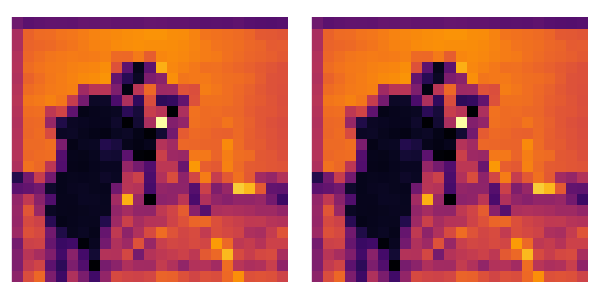

In [57]:
layer = 1 # you can change it to any layer you want 
channel = 2 # you can change it to any channel you want, just make sure that it exists

h1 = heatmap(CNN_model[1:layer](input)[:, :, channel, 1], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false))
h2 = heatmap(image_pass!(jump, input, cnns, layer)[:, :, channel], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false))
display(MIME"image/png"(), plot(h1, h2, layout=(1, 2), size=(600, 300)))

As you can see the output of out formulation is approximately the same as the output of true layer. You can experiment with differemt values of `layer` and `channel` to ensure that the output is correct.